## Coastal Mask

Notebook environment to migrate TIF files to CF compliant CoG

In [1]:
# Optional; code formatter, installed as jupyter lab extension
#%load_ext lab_black
# Optional; code formatter, installed as jupyter notebook extension
%load_ext nb_black

<IPython.core.display.Javascript object>

### Configure OS independent paths

In [2]:
# Import standard packages
import os
import pathlib
import sys
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import xarray as xr
from dotenv import load_dotenv
import math
from pathlib import Path
from typing import Any, Dict, List, Optional, Tuple, Union
import rioxarray as rio
#load_dotenv()

# Import custom functionality
from coclicodata.drive_config import p_drive
from coclicodata.etl.cf_compliancy_checker import check_compliancy, save_compliancy
from coastmonitor.io.utils import name_block

# Define (local and) remote drives
coclico_data_dir = p_drive.joinpath("11207608-coclico", "FULLTRACK_DATA")

# Workaround to the Windows OS (10) udunits error after installation of cfchecker: https://github.com/SciTools/iris/issues/404
os.environ["UDUNITS2_XML_PATH"] = str(
    pathlib.Path().home().joinpath(  # change to the udunits2.xml file dir in your Python installation
        r"Anaconda3\pkgs\udunits2-2.2.28-h892ecd3_0\Library\share\udunits\udunits2.xml"
    )
)

# use local or remote data dir
use_local_data = False
ds_dirname = "WP4"

if use_local_data: 
    ds_dir = pathlib.Path().home().joinpath("data", "tmp", ds_dirname)
else: 
    ds_dir = coclico_data_dir.joinpath(ds_dirname)

if not ds_dir.exists():
    raise FileNotFoundError("Directory with data does not exist.")

# directory to export result (make if not exists)
cog_dir = ds_dir.joinpath("cog") # for checking CF compliancy
cog_dirs = ds_dir.joinpath("cogs") # for making all files CF compliant
cog_dir.mkdir(parents=True, exist_ok=True)

C:\Users\soest\AppData\Local\Temp\ipykernel_2324\1135542707.py:6: DeprecationWarning: Shapely 2.0 is installed, but because PyGEOS is also installed, GeoPandas still uses PyGEOS by default. However, starting with version 0.14, the default will switch to Shapely. To force to use Shapely 2.0 now, you can either uninstall PyGEOS or set the environment variable USE_PYGEOS=0. You can do this before starting the Python process, or in your code before importing geopandas:

import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

In the next release, GeoPandas will switch to using Shapely by default, even if PyGEOS is installed. If you only have PyGEOS installed to get speed-ups, this switch should be smooth. However, if you are using PyGEOS directly (calling PyGEOS functions on geometries from GeoPandas), this will then stop working and you are encouraged to migrate from PyGEOS to Shapely 2.0 (https://shapely.readthedocs.io/en/latest/migration_pygeos.html).
  import geopandas as gpd


<IPython.core.display.Javascript object>

In [3]:
# Project paths & files (manual input)
test_path = ds_dir.joinpath("data","TEST_MAPS","RP100_LD.tif")
CF_dir = ds_dir.joinpath("CF")

<IPython.core.display.Javascript object>

In [4]:
# NetCDF attribute alterations by means of metadata template
import json
meta_json = open(ds_dir.joinpath("data","TEST_MAPS","Metadata", "RP100_HD.json"), 'r')
meta_data = json.load(meta_json)

## NOTE: original json file gives an error. At the end of the block for KEYWORDS and TAGS an extra comma and enter needed to be deleted. 

<IPython.core.display.Javascript object>

In [5]:
def generate_slices(num_chunks: int, chunk_size: int) -> Tuple[slice, slice]:
    """Generate slices for chunk-based iteration."""
    for i in range(num_chunks):
        yield slice(i * chunk_size, (i + 1) * chunk_size)


fm = xr.open_dataset(
    test_path, engine="rasterio", mask_and_scale=False
)  # .isel({"x":slice(0, 40000), "y":slice(0, 40000)})
fm = fm.assign_coords(band=("band", [f"B{k+1:02}" for k in range(fm.dims["band"])]))
fm = fm["band_data"].to_dataset("band")

# chunk size 
chunk_size = 2**12 # 16384, which is large, but OK for int8 datatype.

fm_chunked = fm.chunk({"x": chunk_size, "y": chunk_size})

num_x_chunks = math.ceil(fm_chunked.dims["x"] / chunk_size)
num_y_chunks = math.ceil(fm_chunked.dims["y"] / chunk_size)

for x_slice in generate_slices(num_x_chunks, chunk_size):
    for y_slice in generate_slices(num_y_chunks, chunk_size):
        chunk = fm_chunked.isel(x=x_slice, y=y_slice)

        chunk = chunk.assign_coords(time=pd.Timestamp(2022, 2, 22).isoformat())

        for var in chunk:
            da = chunk[var]

            da = (
                da.where(da != -9999, 0)
                .astype("uint8")
                .rio.write_nodata(0)
                .rio.set_spatial_dims(x_dim="x", y_dim="y")
            )

            item_name = name_block(
                da,
                storage_prefix="",
                name_prefix="",
                include_band=da.name,
                time_dim=False,
                x_dim="x",
                y_dim="y",
            )

            # convert to dataset
            dad = da.to_dataset()

            # add all attributes (again)
            for attr_name, attr_val in meta_data.items():
                if attr_name == 'PROVIDERS':
                    attr_val = json.dumps(attr_val)
                if attr_name == "MEDIA_TYPE": # change media type to tiff, leave the rest as is
                    attr_val = "IMAGE/TIFF"
                dad.attrs[attr_name] = attr_val

            dad.attrs['Conventions'] = "CF-1.8"

            # export file
            outpath = cog_dir.joinpath(item_name)
            dad.rio.to_raster(outpath, compress="DEFLATE", driver="COG")

        break
    break

c:\Users\soest\AppData\Local\mambaforge\envs\coclico\Lib\site-packages\dask\array\chunk.py:278: RuntimeWarning: invalid value encountered in cast
  return x.astype(astype_dtype, **kwargs)


<IPython.core.display.Javascript object>

In [6]:
# export to nc for quick CF compliancy check..
dad.to_netcdf(path=cog_dir.joinpath(item_name.replace(".tif", ".nc")))

CF_dir

WindowsPath('P:/11207608-coclico/FULLTRACK_DATA/WP4/CF')

<IPython.core.display.Javascript object>

In [7]:
%%capture cap --no-stderr
# check original CF compliancy

check_compliancy(testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)

<IPython.core.display.Javascript object>

In [8]:
# save original CF compliancy
save_compliancy(cap, testfile=cog_dir.joinpath(item_name.replace(".tif", ".nc")), working_dir=CF_dir)

{'P:\\11207608-coclico\\FULLTRACK_DATA\\WP4\\cog\\B01_x2639287.5_y5313287.5.nc': {'warnings': '8', 'errors': '1'}}


<IPython.core.display.Javascript object>

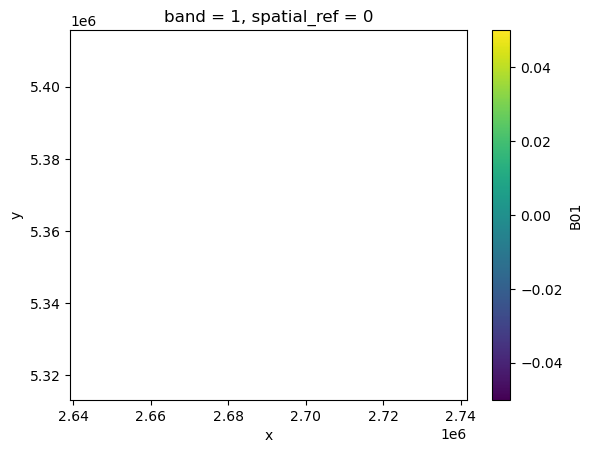

<IPython.core.display.Javascript object>

In [9]:
# plot to check output
data = rio.open_rasterio(outpath, masked=True)
data.plot()
#rds.plot()

fm_data = rio.open_rasterio(r'p:\11207608-coclico\FASTTRACK_DATA\19_coastal_mask\cog\B01_x-180.0_y81.59.tif', masked = True)
fm_data.plot

### Test singel chunked tif, with data (not just nan's) to see if code is working


In [10]:
# Set up file structure for coastal flooding hazard maps

import glob
import rioxarray
from datacube.utils.cog import write_cog

def generate_slices(num_chunks: int, chunk_size: int) -> Tuple[slice, slice]:
    """Generate slices for chunk-based iteration."""
    for i in range(num_chunks):
        yield slice(i * chunk_size, (i + 1) * chunk_size)

def get_paths(folder_structure, base_dir=''):
    """Generate paths for a folder structure defined by a dict"""
    paths = []
    for key, value in folder_structure.items():
        if isinstance(value, dict):
            paths.extend(get_paths(value, os.path.join(base_dir, key)))
        elif isinstance(value, list):
            if value:
                for item in value:
                    if item != "":
                        paths.append(os.path.join(base_dir, key, item))
            else:
                paths.append(os.path.join(base_dir, key))
        else:
            continue
    return paths

# List different types on map folders
map_types = [   'HIGH_DEFENDED_MAPS',
                'LOW_DEFENDED_MAPS',
                'UNDEFENDED_MAPS']

# List all tif files present in first folder (note: it is assumed that the same files are present in all folders)
tif_list = glob.glob(str(ds_dir.joinpath("data", map_types[0],"*.tif")))

# List the desired folder structure as a dict
# NOTE: make sure the resulting path_list (based on folder structure) matches the tif_list
folder_structure = {
    "Mean_spring_tide": [],
    "RP": ["1000", "100", "1"],
    "SLR": {
        "High_end": ["2100", "2150"],
        "SSP126": ["2100"],
        "SSP245": ["2050", "2100"],
        "SSP585": ["2030", "2050", "2100"]
    }
}

# Get list of paths for the folder structure
path_list = get_paths(folder_structure)

# Iterate over the original tif files
for map_type in ['HIGH_DEFENDED_MAPS']:
    for cur_path, cur_tif in zip([path_list[1]], [tif_list[1]]):

        print('currently working on: '+str(cur_path)+' '+str(cur_tif))
        
        cur_dir = pathlib.Path(os.path.join(cog_dirs,map_type,cur_path))
        cur_dir.mkdir(parents=True,exist_ok=True)

        fm = rioxarray.open_rasterio(
            cur_tif, mask_and_scale=False
        )  # .isel({"x":slice(0, 40000), "y":slice(0, 40000)})
        fm = fm.assign_coords(band=("band", [f"B{k+1:02}" for k in range(1)])) # NOTE: hard coded to 1, because one band
        fm = fm.to_dataset("band")

        # chunk size 
        chunk_size = 2**12 # 16384, which is large, but OK for int8 datatype.

        fm_chunked = fm.chunk({"x": chunk_size, "y": chunk_size})

        num_x_chunks = math.ceil(fm_chunked.dims["x"] / chunk_size)
        num_y_chunks = math.ceil(fm_chunked.dims["y"] / chunk_size)

        # Load meta data
        cur_meta_data = open(os.path.join(os.path.dirname(cur_tif),'Metadata',os.path.basename(cur_tif.replace('tif','json'))))
        cur_meta = json.load(cur_meta_data)

        for x_slice in generate_slices(num_x_chunks, chunk_size):
            for y_slice in generate_slices(num_y_chunks, chunk_size):
                chunk = fm_chunked.isel(x=x_slice, y=y_slice)

                chunk = chunk.assign_coords(time=pd.Timestamp(2024, 3, 18).isoformat())

                for var in chunk:
                    print(x_slice, y_slice)

                    da = chunk[var]

                    da = (
                        da.where(da != 3.3999999521443642e+38,-9999)
                        .astype("float32")
                        .rio.write_nodata(-9999)
                        .rio.set_spatial_dims(x_dim="x", y_dim="y")
                    )

                    item_name = name_block(
                        da,
                        storage_prefix="",
                        name_prefix="",
                        include_band=da.name,
                        time_dim=False,
                        x_dim="x",
                        y_dim="y",
                    )

                    print(item_name)

                    if item_name == r'B01_x4210162.5_y3367662.5.tif':

                        # convert to dataset
                        dad = da.to_dataset()

                        # add all attributes (again)
                        for attr_name, attr_val in cur_meta.items():
                            if attr_name == 'PROVIDERS':
                                attr_val = json.dumps(attr_val)
                            if attr_name == "MEDIA_TYPE": # change media type to tiff, leave the rest as is
                                attr_val = "IMAGE/TIFF"
                            dad.attrs[attr_name] = attr_val

                        dad.attrs['Conventions'] = "CF-1.8"

                        # make parent dir if not exists
                        outpath = cur_dir.joinpath(item_name)
                        outpath.parent.mkdir(parents=True, exist_ok=True)

                        # export file
                        dad.rio.to_raster(outpath, driver="COG")

                        break
                    if item_name == r'B01_x4210162.5_y3367662.5.tif': break

                if item_name == r'B01_x4210162.5_y3367662.5.tif': break

            if item_name == r'B01_x4210162.5_y3367662.5.tif': break

        if item_name == r'B01_x4210162.5_y3367662.5.tif': break

    if item_name == r'B01_x4210162.5_y3367662.5.tif': break
                    # set overwrite is false because tifs should be unique
                    # try:
                    #     write_cog(da, fname=outpath, overwrite=False).compute()
                    # except OSError as e:
                    #     continue


currently working on: RP\1000 P:\11207608-coclico\FULLTRACK_DATA\WP4\data\HIGH_DEFENDED_MAPS\RP1000_HD.tif
slice(0, 4096, None) slice(0, 4096, None)
B01_x1547762.5_y5313262.5.tif
slice(0, 4096, None) slice(4096, 8192, None)
B01_x1547762.5_y5210862.5.tif
slice(0, 4096, None) slice(8192, 12288, None)
B01_x1547762.5_y5108462.5.tif
slice(0, 4096, None) slice(12288, 16384, None)
B01_x1547762.5_y5006062.5.tif
slice(0, 4096, None) slice(16384, 20480, None)
B01_x1547762.5_y4903662.5.tif
slice(0, 4096, None) slice(20480, 24576, None)
B01_x1547762.5_y4801262.5.tif
slice(0, 4096, None) slice(24576, 28672, None)
B01_x1547762.5_y4698862.5.tif
slice(0, 4096, None) slice(28672, 32768, None)
B01_x1547762.5_y4596462.5.tif
slice(0, 4096, None) slice(32768, 36864, None)
B01_x1547762.5_y4494062.5.tif
slice(0, 4096, None) slice(36864, 40960, None)
B01_x1547762.5_y4391662.5.tif
slice(0, 4096, None) slice(40960, 45056, None)
B01_x1547762.5_y4289262.5.tif
slice(0, 4096, None) slice(45056, 49152, None)
B01_x15

<IPython.core.display.Javascript object>

In [11]:
# Check if resulting tif has same pixel values, for a random pixel with data
test = rioxarray.open_rasterio(r'p:\11207608-coclico\FULLTRACK_DATA\WP4\cogs\HIGH_DEFENDED_MAPS\RP\1000\B01_x4210162.5_y3367662.5.tif')
print(test.values[0][1400,2000])
print(da.values[1400,2000])


0.27593374
0.27593374


<IPython.core.display.Javascript object>

In [12]:
# NOTE: Not all meta_data.json files were correct and will break the loop. 
# CHECK if all meta_data 

for map_type in map_types:
    for cur_path, cur_tif in zip(path_list, tif_list):
        
        print('trying to open: ' + str(os.path.basename(cur_tif.replace('tif','json'))))
        
        # Load meta data
        cur_meta_data = open(os.path.join(os.path.dirname(cur_tif),'Metadata',os.path.basename(cur_tif.replace('tif','json'))))
        cur_meta = json.load(cur_meta_data)

        if map_type == map_types[-1] and cur_tif == tif_list[-1]:
            print('All .json files are working')

        


trying to open: Mean_spring_tide_HD.json
trying to open: RP1000_HD.json
trying to open: RP100_HD.json
trying to open: RP1_HD.json
trying to open: SLR_High-End_2100_subs_2050_HD.json
trying to open: SLR_High-End_2150_subs_2050_HD.json
trying to open: SLR_SSP126_2100_subs_2050_HD.json
trying to open: SLR_SSP245_2050_subs_HD.json
trying to open: SLR_SSP245_2100_subs_2050_HD.json
trying to open: SLR_SSP585_2030_subs_HD.json
trying to open: SLR_SSP585_2050_subs_HD.json
trying to open: SLR_SSP585_2100_subs_2050_HD.json
trying to open: Mean_spring_tide_HD.json
trying to open: RP1000_HD.json
trying to open: RP100_HD.json
trying to open: RP1_HD.json
trying to open: SLR_High-End_2100_subs_2050_HD.json
trying to open: SLR_High-End_2150_subs_2050_HD.json
trying to open: SLR_SSP126_2100_subs_2050_HD.json
trying to open: SLR_SSP245_2050_subs_HD.json
trying to open: SLR_SSP245_2100_subs_2050_HD.json
trying to open: SLR_SSP585_2030_subs_HD.json
trying to open: SLR_SSP585_2050_subs_HD.json
trying to op

<IPython.core.display.Javascript object>

In [13]:
# DO THE WORK

# Iterate over the original tif files
for map_type in map_types:
    for cur_path, cur_tif in zip(path_list, tif_list):

        print('currently working on: '+str(cur_path)+' '+str(cur_tif))
        
        cur_dir = pathlib.Path(os.path.join(cog_dirs,map_type,cur_path))
        cur_dir.mkdir(parents=True,exist_ok=True)

        fm = rioxarray.open_rasterio(
            cur_tif, mask_and_scale=False
        )  # .isel({"x":slice(0, 40000), "y":slice(0, 40000)})
        fm = fm.assign_coords(band=("band", [f"B{k+1:02}" for k in range(1)])) # NOTE: hard coded to 1, because one band
        fm = fm.to_dataset("band")

        # chunk size 
        chunk_size = 2**15 # 16384, which is large, but OK for int8 datatype.

        fm_chunked = fm.chunk({"x": chunk_size, "y": chunk_size})

        num_x_chunks = math.ceil(fm_chunked.dims["x"] / chunk_size)
        num_y_chunks = math.ceil(fm_chunked.dims["y"] / chunk_size)

        # Load meta data
        cur_meta_data = open(os.path.join(os.path.dirname(cur_tif),'Metadata',os.path.basename(cur_tif.replace('tif','json'))))
        cur_meta = json.load(cur_meta_data)

        for x_slice in generate_slices(num_x_chunks, chunk_size):
            for y_slice in generate_slices(num_y_chunks, chunk_size):
                chunk = fm_chunked.isel(x=x_slice, y=y_slice)

                chunk = chunk.assign_coords(time=pd.Timestamp(2024, 3, 18).isoformat())

                for var in chunk:
                    print(x_slice, y_slice)

                    da = chunk[var]

                    da = (
                        da.where(da != 3.3999999521443642e+38,-9999)
                        .astype("float32")
                        .rio.write_nodata(-9999)
                        .rio.set_spatial_dims(x_dim="x", y_dim="y")
                    )

                    item_name = name_block(
                        da,
                        storage_prefix="",
                        name_prefix="",
                        include_band=da.name,
                        time_dim=False,
                        x_dim="x",
                        y_dim="y",
                    )

                    print(item_name)

                    # convert to dataset
                    dad = da.to_dataset()

                    # add all attributes (again)
                    for attr_name, attr_val in cur_meta.items():
                        if attr_name == 'PROVIDERS':
                            attr_val = json.dumps(attr_val)
                        if attr_name == "MEDIA_TYPE": # change media type to tiff, leave the rest as is
                            attr_val = "IMAGE/TIFF"
                        dad.attrs[attr_name] = attr_val

                    dad.attrs['Conventions'] = "CF-1.8"

                    # make parent dir if not exists
                    outpath = cur_dir.joinpath(item_name)
                    outpath.parent.mkdir(parents=True, exist_ok=True)

                    # export file
                    dad.rio.to_raster(outpath, compress="DEFLATE", driver="COG")

                    # set overwrite is false because tifs should be unique
                    # try:
                    #     write_cog(da, fname=outpath, overwrite=False).compute()
                    # except OSError as e:
                    #     continue


currently working on: Mean_spring_tide P:\11207608-coclico\FULLTRACK_DATA\WP4\data\HIGH_DEFENDED_MAPS\Mean_spring_tide_HD.tif
slice(0, 32768, None) slice(0, 32768, None)
B01_x2924487.5_y4596737.5.tif
slice(0, 32768, None) slice(32768, 65536, None)
B01_x2924487.5_y3777537.5.tif
slice(0, 32768, None) slice(65536, 98304, None)
B01_x2924487.5_y2958337.5.tif
slice(0, 32768, None) slice(98304, 131072, None)
B01_x2924487.5_y2139137.5.tif
slice(0, 32768, None) slice(131072, 163840, None)
B01_x2924487.5_y1385887.5.tif
slice(32768, 65536, None) slice(0, 32768, None)
B01_x3743687.5_y4596737.5.tif
slice(32768, 65536, None) slice(32768, 65536, None)
B01_x3743687.5_y3777537.5.tif
slice(32768, 65536, None) slice(65536, 98304, None)
B01_x3743687.5_y2958337.5.tif
slice(32768, 65536, None) slice(98304, 131072, None)
B01_x3743687.5_y2139137.5.tif
slice(32768, 65536, None) slice(131072, 163840, None)
B01_x3743687.5_y1385887.5.tif
slice(65536, 98304, None) slice(0, 32768, None)
B01_x4562887.5_y4596737.5.ti

<bound method DatasetAggregations.max of <xarray.Dataset>
Dimensions:      (y: 178961, x: 199128)
Coordinates:
  * x            (x) float64 1.548e+06 1.548e+06 ... 6.526e+06 6.526e+06
  * y            (y) float64 5.416e+06 5.416e+06 ... 9.417e+05 9.416e+05
    spatial_ref  int32 0
Data variables:
    B01          (y, x) float32 ...
Attributes: (12/13)
    AREA_OR_POINT:           Area
    RepresentationType:      ATHEMATIC
    STATISTICS_COVARIANCES:  2.203831395557714
    STATISTICS_MAXIMUM:      6.7783522605896
    STATISTICS_MEAN:         1.5456626132952
    STATISTICS_MEDIAN:       0.957803
    ...                      ...
    STATISTICS_SKIPFACTORX:  1
    STATISTICS_SKIPFACTORY:  1
    STATISTICS_STDDEV:       1.4845306987589
    _FillValue:              3.4e+38
    scale_factor:            1.0
    add_offset:              0.0>

<IPython.core.display.Javascript object>

In [235]:
np.min(dad['B01'].values)

0.001

<IPython.core.display.Javascript object>